<a href="https://colab.research.google.com/github/LakshyaTangri/LakshyaTangri.github.io/blob/main/Hospital_BIll_Both_Models_Uni_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [3]:
# Install required packages
!pip install optuna
!pip install scipy
!pip install tensorflow
!pip install shap

# Importing Libraries
import pandas as pd
import numpy as np
import time
import optuna
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import zscore
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.2 MB/s eta 0:00:00


This section imports necessary libraries for data manipulation, visualization, machine learning, and deep learning. Here's a summary:

pandas (pd): Used for data handling and manipulation with DataFrames.
numpy (np): Provides numerical computing tools, especially for arrays.
time: Used for timing operations.
optuna: A library for hyperparameter optimization.
shap: Used for model interpretability.
seaborn (sns): Creates statistical visualizations.
matplotlib.pyplot (plt): Another visualization library.
sklearn: Provides a wide range of machine learning tools, including data preprocessing, model training, and evaluation.
scipy: Used for scientific and technical computing.
tensorflow: A deep learning library, used here for building and training neural networks.

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

# Create a function to visualize the distribution of the target variable
def visualize_target_distribution(data, target_col, log_transform=False):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(data[target_col], kde=True)
    plt.title(f'Distribution of {target_col}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[target_col])
    plt.title(f'Boxplot of {target_col}')

    plt.tight_layout()
    plt.show()

    if log_transform:
        plt.figure(figsize=(12, 5))

        log_target = np.log1p(data[target_col])

        plt.subplot(1, 2, 1)
        sns.histplot(log_target, kde=True)
        plt.title(f'Distribution of Log-Transformed {target_col}')

        plt.subplot(1, 2, 2)
        sns.boxplot(x=log_target)
        plt.title(f'Boxplot of Log-Transformed {target_col}')

        plt.tight_layout()
        plt.show()

# Function to visualize feature correlations
def visualize_correlations(data, numerical_features):
    plt.figure(figsize=(12, 10))
    corr = data[numerical_features].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(corr, annot=True, cmap="coolwarm", mask=mask, vmin=-1, vmax=1)
    plt.title("Feature Correlation Heatmap")
    plt.tight_layout()
    plt.show()

# Function to visualize feature importance
def visualize_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        # For tree-based models
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        plt.title('Feature Importance')
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()

# Function to visualize actual vs predicted values
def visualize_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))

    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    # Scatter plot
    plt.scatter(y_true, y_pred, alpha=0.5)

    # Add perfect prediction line
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.title(f'{model_name}: Actual vs Predicted Values\nRMSE: {rmse:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Function to visualize residuals
def visualize_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred

    plt.figure(figsize=(12, 5))

    # Residual histogram
    plt.subplot(1, 2, 1)
    sns.histplot(residuals, kde=True)
    plt.title(f'{model_name}: Residuals Distribution')
    plt.xlabel('Residual Value')

    # Residual vs Predicted
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title(f'{model_name}: Residuals vs Predicted')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residual Values')

    plt.tight_layout()
    plt.show()

# Function to visualize model comparison
def visualize_model_comparison(results, metric_name="MAPE (%)"):
    plt.figure(figsize=(10, 6))

    models = list(results.keys())
    values = list(results.values())

    # Sort by performance (assuming lower is better)
    sorted_indices = np.argsort(values)
    sorted_models = [models[i] for i in sorted_indices]
    sorted_values = [values[i] for i in sorted_indices]

    # Use different colors for different models
    colors = sns.color_palette("viridis", len(sorted_models))

    bars = plt.bar(sorted_models, sorted_values, color=colors)

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}%', ha='center', va='bottom', rotation=0)

    plt.ylabel(metric_name)
    plt.title(f"Model Comparison for Billing Amount Prediction")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Function to visualize SHAP values for model interpretation
def visualize_shap(model, X, feature_names, model_name, n_samples=100):
    # For large datasets, use a sample
    if X.shape[0] > n_samples:
        X_sample = X[np.random.choice(X.shape[0], n_samples, replace=False)]
    else:
        X_sample = X

    plt.figure(figsize=(12, 10))
    plt.title(f"SHAP Feature Importance for {model_name}")

    # For tree-based models
    if hasattr(model, 'estimators_'):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)

        plt.subplot(2, 1, 1)
        shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
        plt.title(f"SHAP Feature Impact for {model_name}")

        plt.subplot(2, 1, 2)
        shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)
        plt.title(f"SHAP Feature Importance for {model_name}")

    plt.tight_layout()
    plt.show()

# Function to visualize training history for neural network models
def visualize_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    if 'lr' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['lr'])
        plt.title('Learning Rate During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')

    plt.tight_layout()
    plt.show()

# Function to visualize learning curves (for exploring overfitting)
def visualize_learning_curves(model, X_train, y_train, cv=5):
    from sklearn.model_selection import learning_curve

    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title('Learning Curves')
    plt.xlabel('Training Examples')
    plt.ylabel('MSE')
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color='orange')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Cross-validation score')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()



# Data Loading and Preprocessing

Dataset information:
Number of samples: 55500
Columns: ['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition', 'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider', 'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date', 'Medication', 'Test Results']

Missing values per column:
Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
dtype: int64

Descriptive statistics:
                Age  Billing Amount   Room Number
count  55500.000000    55500.000000  55500.000000
mean      51.539459    25539.316097    301.134829
std       19.602454    14211.454431    115.243069
min       13.000000    -2008.492140    101.000000
25%       35.000000    13241.224652    202.0

<ipython-input-5-59a36d87ba98>:18: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors="coerce", dayfirst=True)


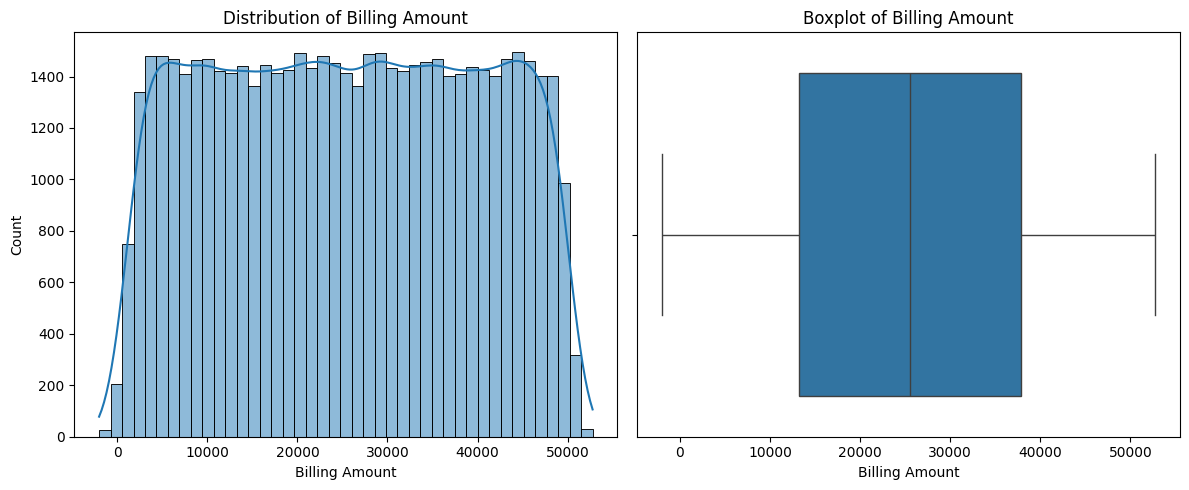

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


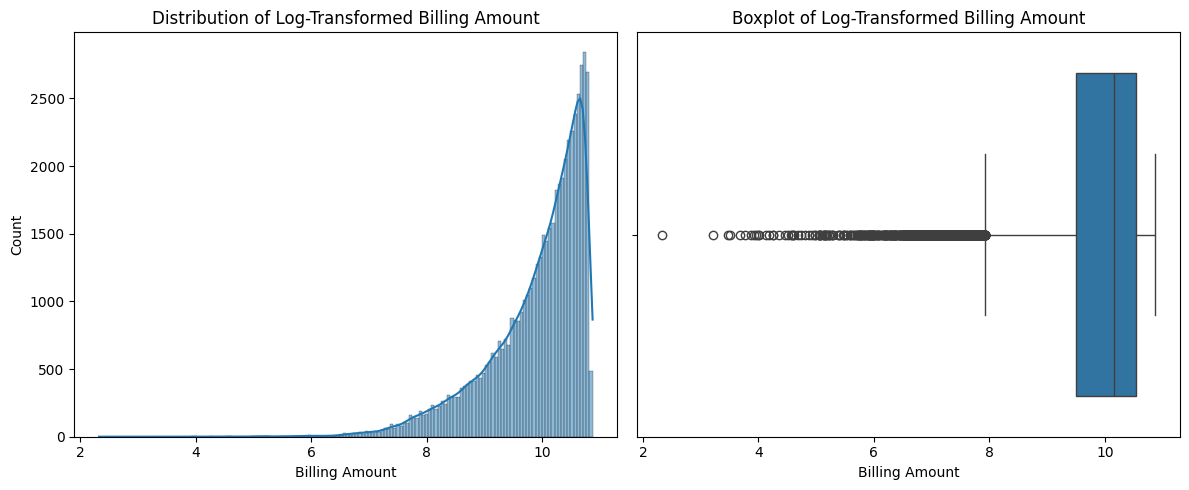

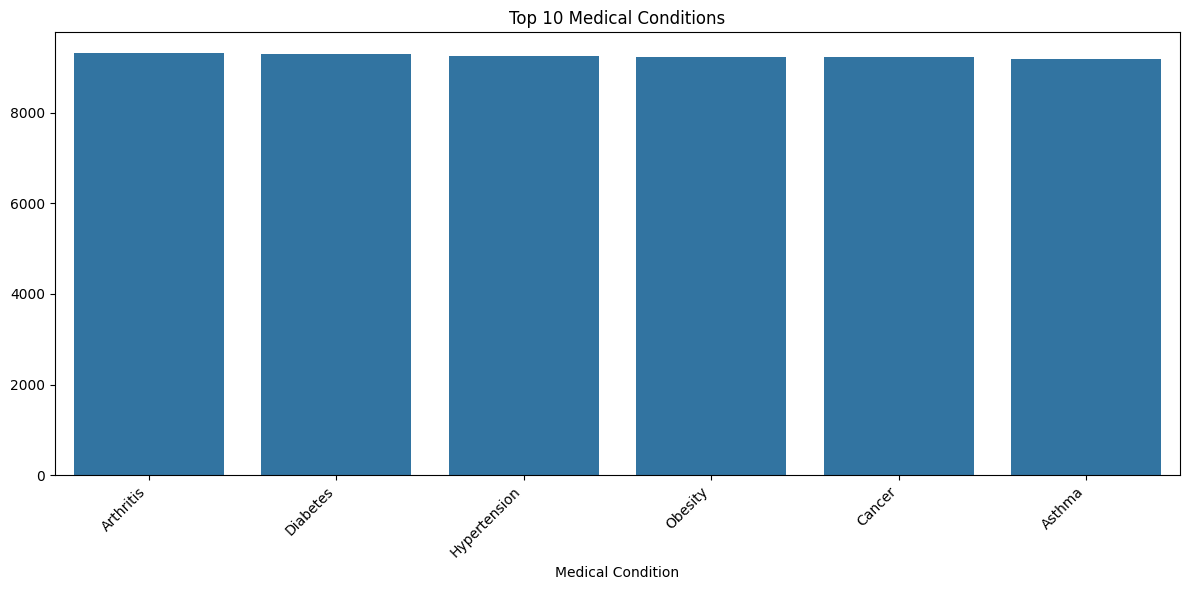


Number of outliers removed: 0
Number of records with non-positive billing: 108


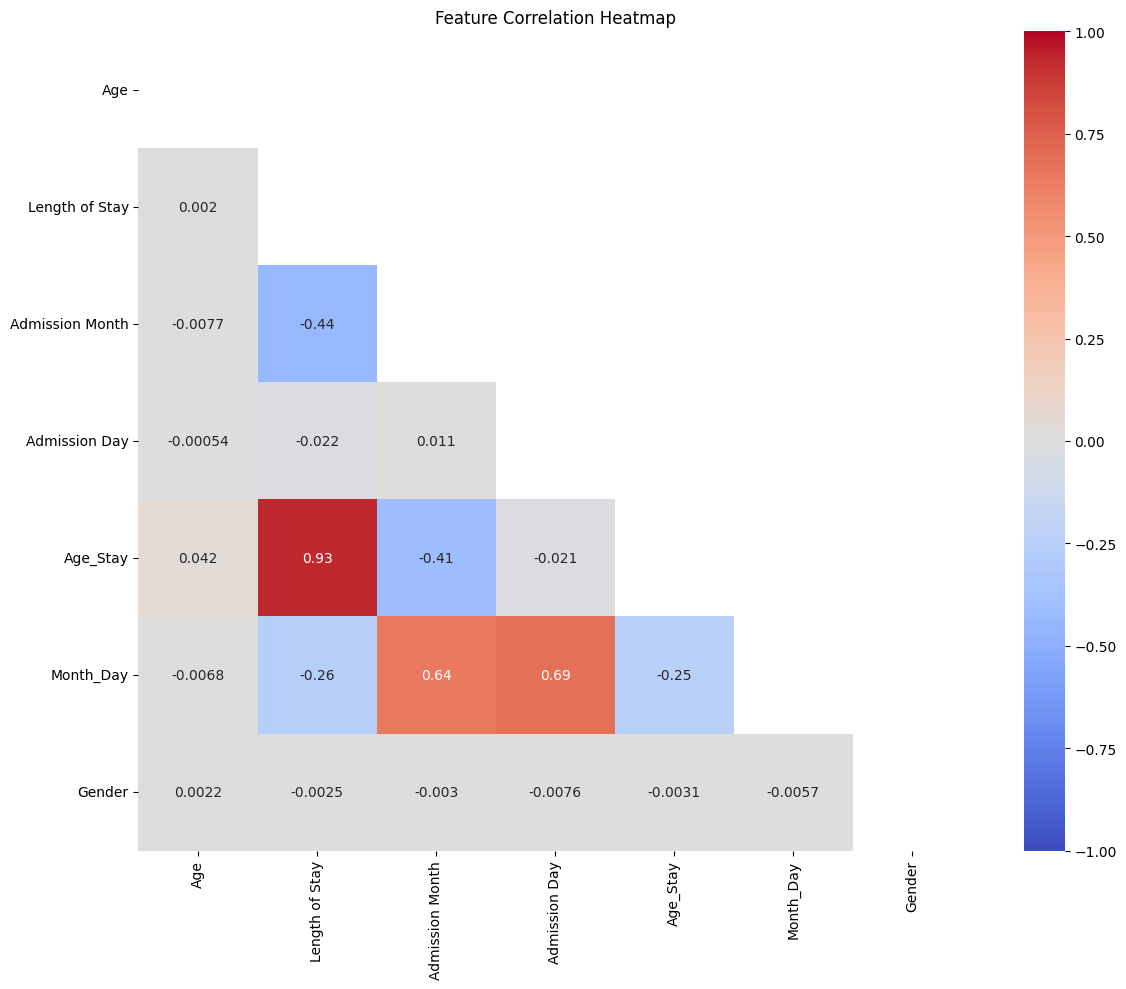

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [5]:
# Data Loading and Preprocessing
# Load dataset
data = pd.read_csv("/content/healthcare_dataset.csv")

# Display basic information about the dataset
print("Dataset information:")
print(f"Number of samples: {len(data)}")
print(f"Columns: {list(data.columns)}")
print("\nMissing values per column:")
print(data.isnull().sum())

# Display descriptive statistics
print("\nDescriptive statistics:")
print(data.describe())

# Convert date columns and create Length of Stay
for col in ["Date of Admission", "Discharge Date"]:
    data[col] = pd.to_datetime(data[col], errors="coerce", dayfirst=True)
data["Length of Stay"] = (data["Discharge Date"] - data["Date of Admission"]).dt.days

# Extract features
data["Admission Month"] = data["Date of Admission"].dt.month
data["Admission Day"] = data["Date of Admission"].dt.day

# Visualize target variable before transformation
visualize_target_distribution(data, "Billing Amount", log_transform=True)

# Drop unnecessary columns
columns_to_drop = ["Name", "Date of Admission", "Discharge Date", "Doctor", "Hospital", "Room Number",
                   "Blood Type", "Admission Type", "Medication", "Test Results", "Insurance Provider"]
data.drop(columns=columns_to_drop, inplace=True)

# Convert Gender to numerical feature
data["Gender"] = data["Gender"].map({"Male": 0, "Female": 1})

# Display diagnosis distribution
plt.figure(figsize=(12, 6))
diagnosis_counts = data["Medical Condition"].value_counts()
top_diagnoses = diagnosis_counts.iloc[:10]
sns.barplot(x=top_diagnoses.index, y=top_diagnoses.values)
plt.title("Top 10 Medical Conditions")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Remove outliers using Z-score
outliers_mask = np.abs(zscore(data["Billing Amount"])) >= 3
print(f"\nNumber of outliers removed: {outliers_mask.sum()}")
data = data[~outliers_mask]

# Ensure no zero or negative values
print(f"Number of records with non-positive billing: {(data['Billing Amount'] <= 0).sum()}")
data = data[data["Billing Amount"] > 0]

# Log transformation of target variable
data["Billing Amount (Original)"] = data["Billing Amount"]
data["Billing Amount"] = np.log1p(data["Billing Amount"])

# Define target variable
y = data["Billing Amount"].values
X = data.drop(columns=["Billing Amount", "Billing Amount (Original)"])

# Feature Engineering
X["Age_Stay"] = X["Age"] * X["Length of Stay"]
X["Month_Day"] = X["Admission Month"] * X["Admission Day"]

# Encode categorical variables
X_encoded = pd.get_dummies(X, columns=["Medical Condition"])

# Numerical features (excluding one-hot encoded columns)
numerical_features = ["Age", "Length of Stay", "Admission Month", "Admission Day", "Age_Stay", "Month_Day", "Gender"]

# Visualize correlations between numerical features
visualize_correlations(X, numerical_features)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features)
], remainder='passthrough')

# Save feature names for later use
feature_names = numerical_features + [col for col in X_encoded.columns if col not in numerical_features]

# Transform data
X_preprocessed = preprocessor.fit_transform(X_encoded)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Impute missing values using IterativeImputer
imputer = IterativeImputer()
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# LSTM requires 3D input
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


This part of the code focuses on preparing the data for model training. It performs these key actions:

Loads the data: Reads the dataset from a CSV file into a pandas DataFrame called data.
Data cleaning and transformation: Converts date columns, calculates the 'Length of Stay', and creates new features like 'Admission Month' and 'Admission Day'. It also removes unnecessary columns, converts categorical features to numerical (e.g., 'Gender'), handles outliers, and applies a log transformation to the target variable ('Billing Amount').
Feature engineering: Creates new features (Age_Stay, Month_Day) by combining existing ones.
Data splitting: Divides the data into training and testing sets using train_test_split.
Data preprocessing: Applies standard scaling to numerical features using StandardScaler.
Missing value imputation: Fills in any missing values using IterativeImputer.
Data reshaping for LSTM: Reshapes the data into a 3D format required by the LSTM model.

# Data Visualization

This code creates two visualizations:

Correlation Heatmap: Shows the correlation between numerical features using sns.heatmap.
Boxplot: Displays the distribution of the 'Billing Amount' using sns.boxplot.

# Model Training and Evaluation

In [8]:

# Model Training and Evaluation
# Hyperparameter tuning for Random Forest
def objective_rf(trial):
    model = RandomForestRegressor(
        n_estimators=trial.suggest_int("n_estimators", 100, 500, step=50),
        max_depth=trial.suggest_int("max_depth", 10, 50, step=10),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        max_features='sqrt',
        random_state=42, n_jobs=1
    )
    model.fit(X_train, y_train)
    return mean_squared_error(y_test, model.predict(X_test))

print("Optimizing Random Forest hyperparameters...")
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=5)
best_rf = study_rf.best_params
print(f"Best Random Forest params: {best_rf}")

rf_model = RandomForestRegressor(**best_rf, random_state=42, n_jobs=1)
rf_model.fit(X_train, y_train)
'''
# Visualize RF learning curve
visualize_learning_curves(RandomForestRegressor(**best_rf, random_state=42), X_train, y_train, cv=3)
'''
# Hyperparameter tuning for MLP
def objective_mlp(trial):
    model = MLPRegressor(
        hidden_layer_sizes=(trial.suggest_int("layer1", 64, 256), trial.suggest_int("layer2", 32, 128)),
        activation=trial.suggest_categorical("activation", ["relu", "tanh"]),
        solver='adam', max_iter=1000, random_state=42, early_stopping=True
    )
    model.fit(X_train, y_train)
    return mean_squared_error(y_test, model.predict(X_test))

print("Optimizing MLP hyperparameters...")
study_mlp = optuna.create_study(direction='minimize')
study_mlp.optimize(objective_mlp, n_trials=5)
best_mlp = study_mlp.best_params
print(f"Best MLP params: {best_mlp}")

mlp_model = MLPRegressor(hidden_layer_sizes=(best_mlp['layer1'], best_mlp['layer2']),
                         activation=best_mlp['activation'],
                         solver='adam', max_iter=1000, random_state=42, early_stopping=True)
mlp_model.fit(X_train, y_train)

# LSTM-GRU Model
print("Training LSTM-GRU model...")
lstm_model = Sequential([
    Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Bidirectional(GRU(128, activation='relu', return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),
    GRU(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1)
])
lstm_model.compile(optimizer="adam", loss="mse")

# Train the LSTM-GRU model and capture training history
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

[I 2025-03-11 17:58:54,971] A new study created in memory with name: no-name-3f93fc86-1652-4fdf-b565-8da72b879ff8


Optimizing Random Forest hyperparameters...


[I 2025-03-11 17:59:26,487] Trial 0 finished with value: 0.7455450415359798 and parameters: {'n_estimators': 200, 'max_depth': 40, 'min_samples_split': 2}. Best is trial 0 with value: 0.7455450415359798.
[I 2025-03-11 17:59:49,396] Trial 1 finished with value: 0.7466406155139345 and parameters: {'n_estimators': 150, 'max_depth': 50, 'min_samples_split': 2}. Best is trial 0 with value: 0.7455450415359798.
[I 2025-03-11 18:00:24,439] Trial 2 finished with value: 0.7153232243608441 and parameters: {'n_estimators': 300, 'max_depth': 50, 'min_samples_split': 7}. Best is trial 2 with value: 0.7153232243608441.
[I 2025-03-11 18:00:48,257] Trial 3 finished with value: 0.7140746709513301 and parameters: {'n_estimators': 200, 'max_depth': 40, 'min_samples_split': 8}. Best is trial 3 with value: 0.7140746709513301.
[I 2025-03-11 18:01:27,706] Trial 4 finished with value: 0.7133553380300028 and parameters: {'n_estimators': 350, 'max_depth': 50, 'min_samples_split': 8}. Best is trial 4 with value: 

Best Random Forest params: {'n_estimators': 350, 'max_depth': 50, 'min_samples_split': 8}


[I 2025-03-11 18:04:17,752] A new study created in memory with name: no-name-dc9826d6-f10c-4010-bd0b-271245c6a91c


Optimizing MLP hyperparameters...


[I 2025-03-11 18:04:41,111] Trial 0 finished with value: 0.7185164915473026 and parameters: {'layer1': 110, 'layer2': 123, 'activation': 'relu'}. Best is trial 0 with value: 0.7185164915473026.
[I 2025-03-11 18:05:01,269] Trial 1 finished with value: 0.70919001867106 and parameters: {'layer1': 152, 'layer2': 33, 'activation': 'tanh'}. Best is trial 1 with value: 0.70919001867106.
[I 2025-03-11 18:05:16,471] Trial 2 finished with value: 0.7191893297121638 and parameters: {'layer1': 178, 'layer2': 64, 'activation': 'relu'}. Best is trial 1 with value: 0.70919001867106.
[I 2025-03-11 18:05:57,019] Trial 3 finished with value: 0.7095945651168125 and parameters: {'layer1': 127, 'layer2': 40, 'activation': 'tanh'}. Best is trial 1 with value: 0.70919001867106.
[I 2025-03-11 18:06:53,238] Trial 4 finished with value: 0.7124858382169268 and parameters: {'layer1': 237, 'layer2': 105, 'activation': 'tanh'}. Best is trial 1 with value: 0.70919001867106.


Best MLP params: {'layer1': 152, 'layer2': 33, 'activation': 'tanh'}
Training LSTM-GRU model...
Epoch 1/50
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - loss: 23.9130 - val_loss: 0.8324 - learning_rate: 0.0010
Epoch 2/50
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - loss: 1.8946 - val_loss: 0.7370 - learning_rate: 0.0010
Epoch 3/50
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 83s 19ms/step - loss: 1.3630 - val_loss: 0.7453 - learning_rate: 0.0010
Epoch 4/50
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - loss: 1.1445 - val_loss: 0.7328 - learning_rate: 0.0010
Epoch 5/50
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 89s 21ms/step - loss: 1.0741 - val_loss: 0.7262 - learning_rate: 0.0010
Epoch 6/50
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 75s 19ms/step - loss: 1.0095 - val_loss: 0.7286 - learning_rate: 0.0010
Epoch 7/50
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 83s 19ms/step - loss: 0.9831 - val_loss: 0.7292 - learning_rate: 0.0010
Epoch 8/50
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - loss: 0.9569 - val_loss: 0.7567 - learning_rate

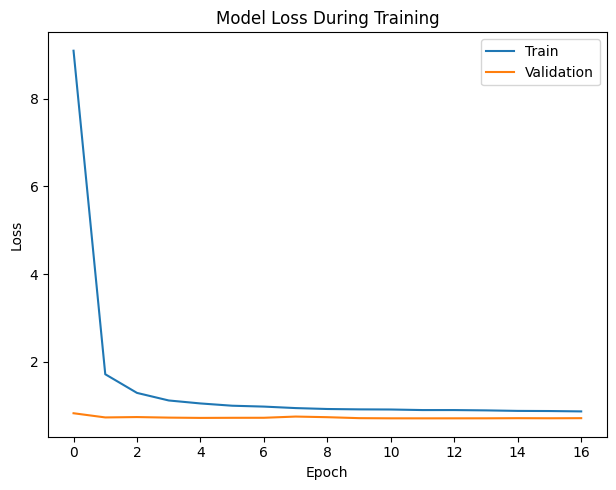

Evaluating Random Forest...
Random Forest performance:
MSE: 0.7201
RMSE: 0.8486
R²: -0.0158
MAPE: 7.08%
---
Evaluating MLP NN...
MLP NN performance:
MSE: 0.7092
RMSE: 0.8421
R²: -0.0004
MAPE: 7.09%
---
Evaluating LSTM-GRU...
347/347 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
LSTM-GRU performance:
MSE: 0.7126
RMSE: 0.8442
R²: -0.0052
MAPE: 7.07%
---


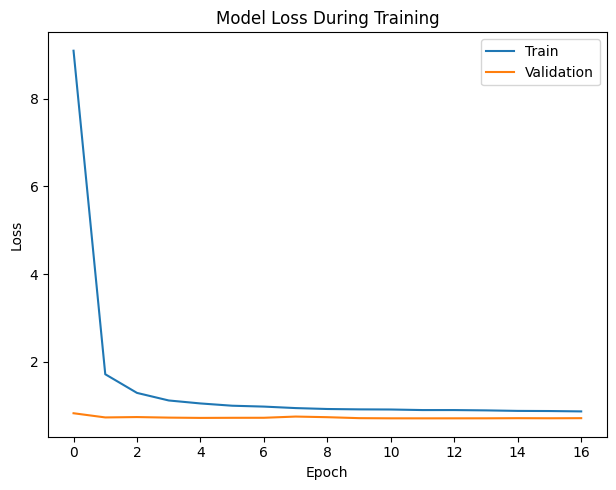

Evaluating Random Forest...
Random Forest performance:
MSE: 0.7201
RMSE: 0.8486
R²: -0.0158
MAPE: 7.08%
---


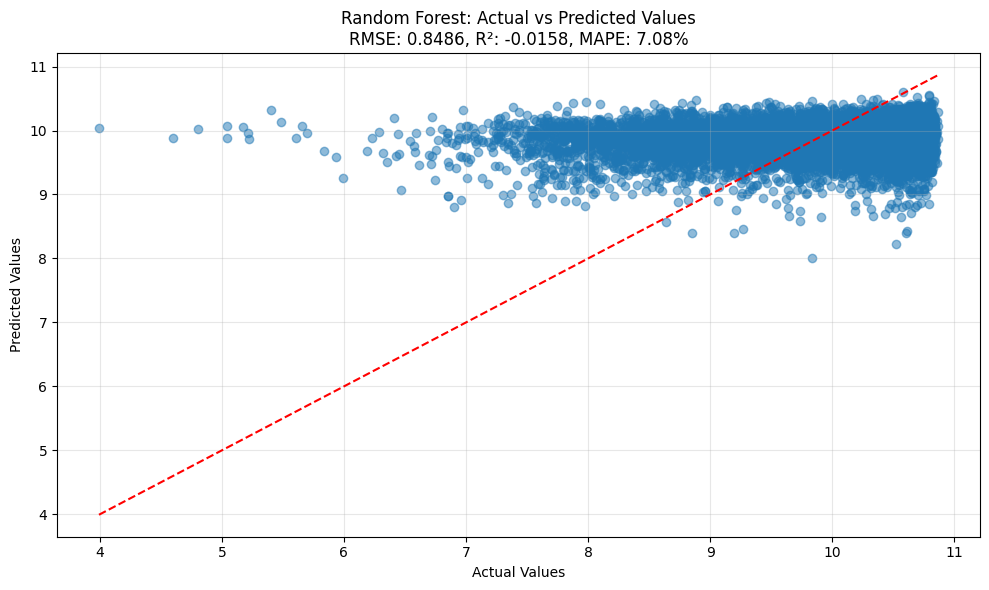

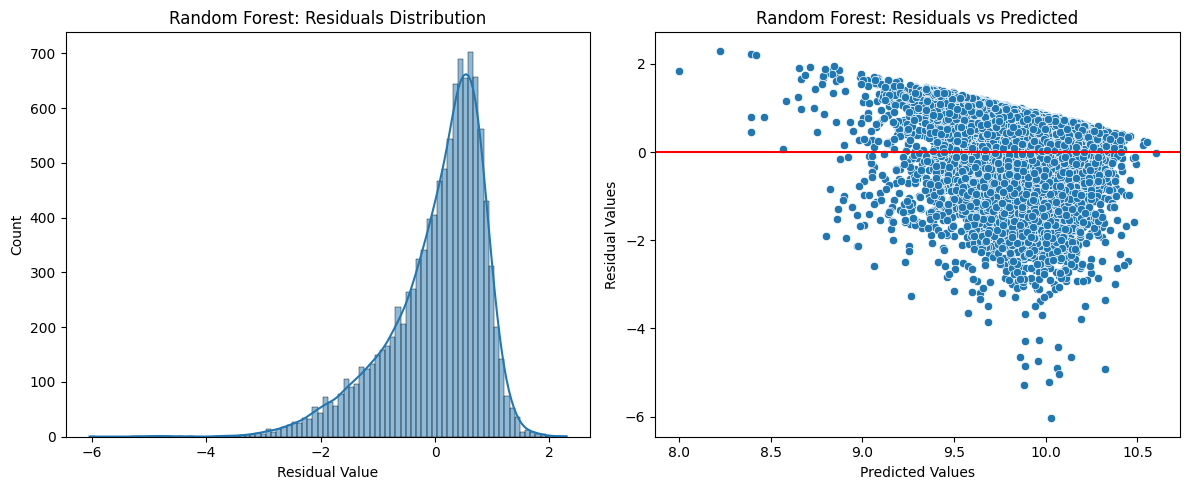

Evaluating MLP NN...
MLP NN performance:
MSE: 0.7092
RMSE: 0.8421
R²: -0.0004
MAPE: 7.09%
---


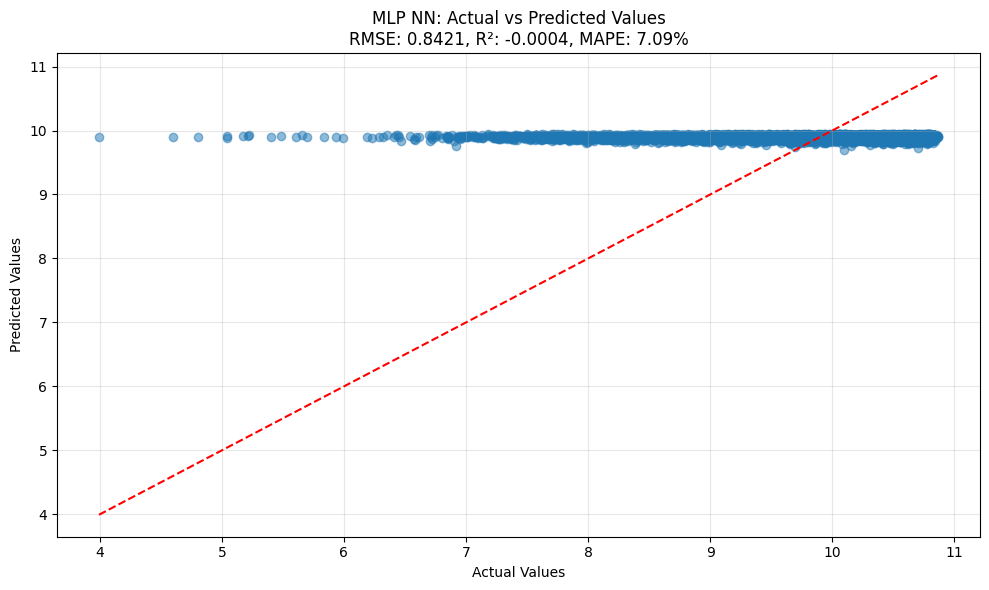

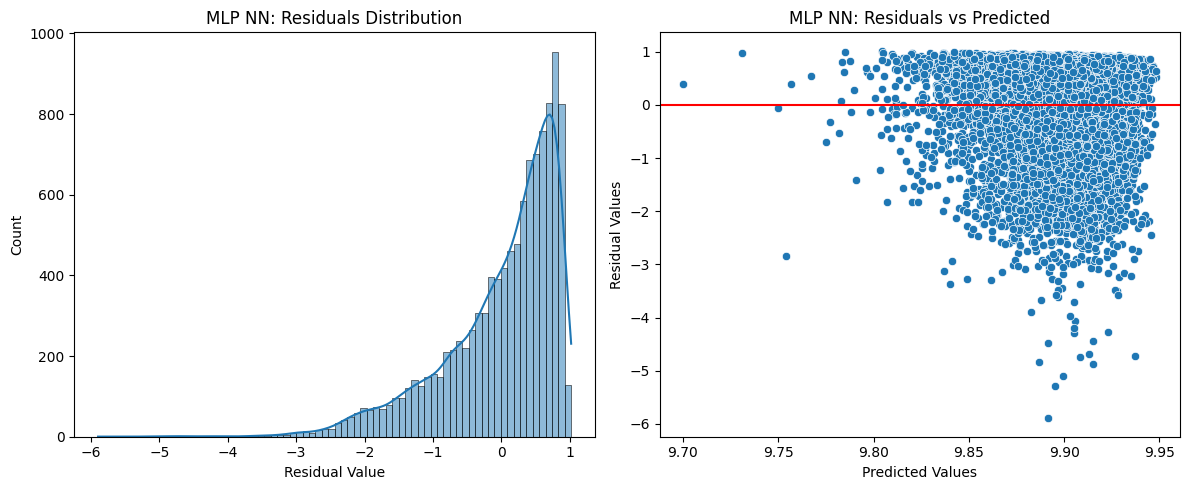

Evaluating LSTM-GRU...
347/347 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
LSTM-GRU performance:
MSE: 0.7126
RMSE: 0.8442
R²: -0.0052
MAPE: 7.07%
---


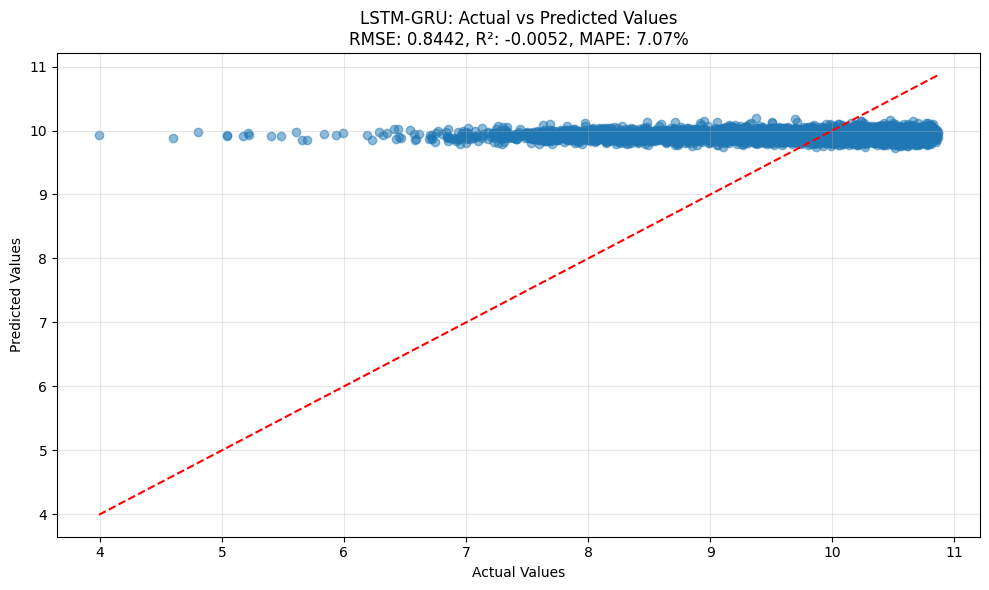

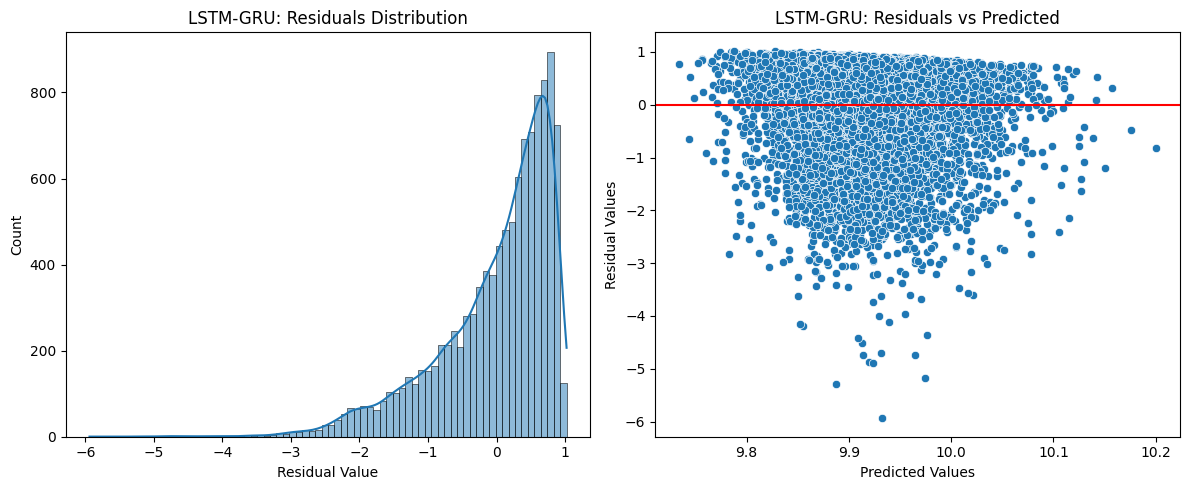

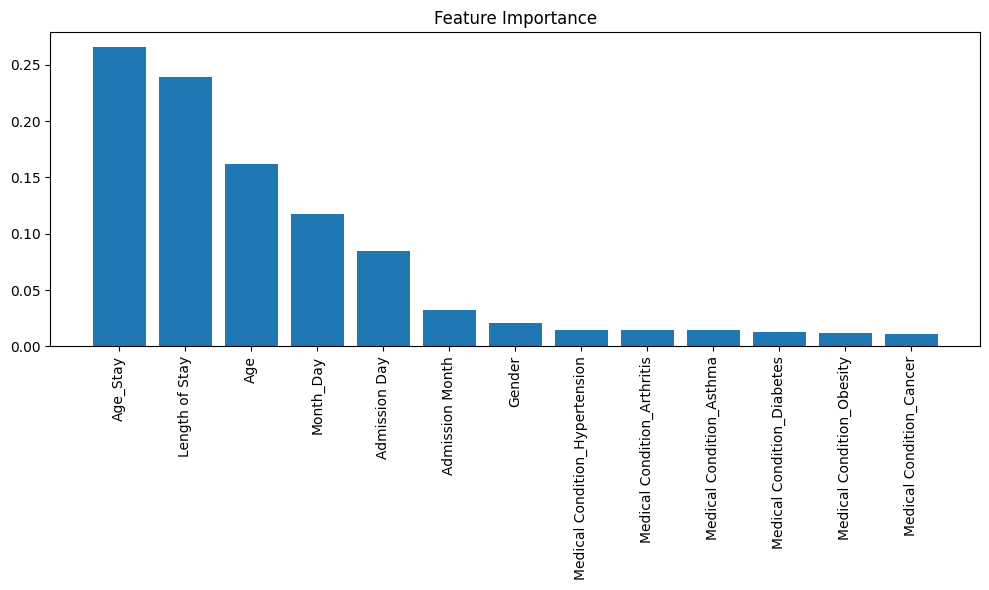

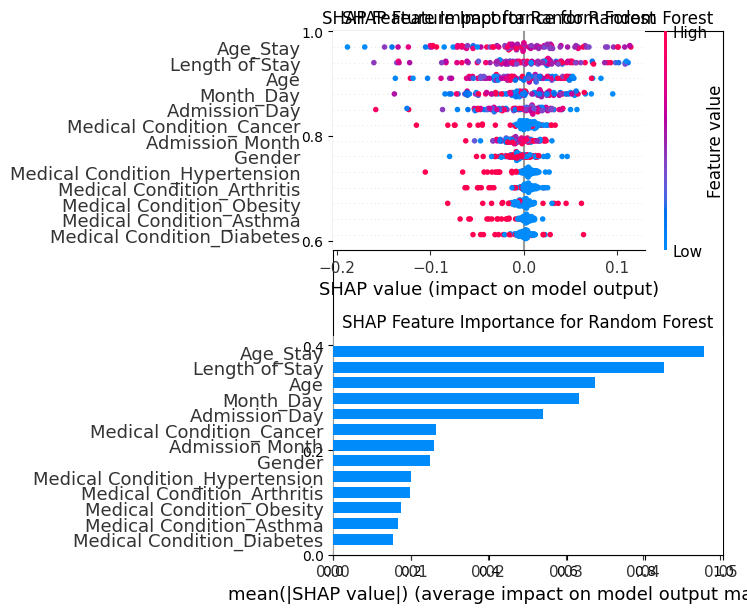

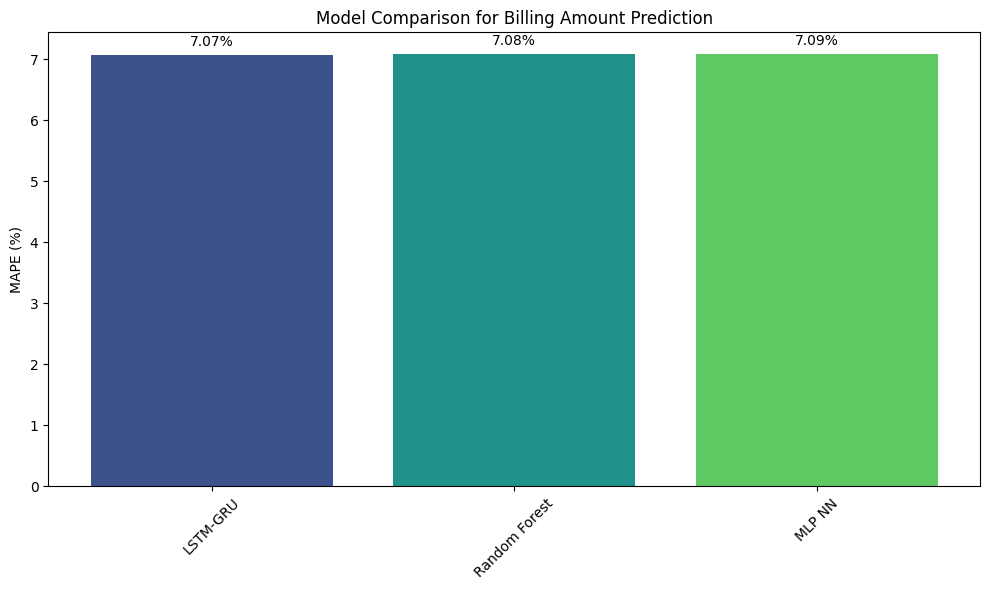

Final MAPE Scores: {'Random Forest': 7.078120580201078, 'MLP NN': 7.08677865916901, 'LSTM-GRU': 7.071979110788146}
Best model: LSTM-GRU with MAPE of 7.07%


In [12]:

# Visualize training history for LSTM-GRU
visualize_training_history(history)

# Evaluate models
models = {"Random Forest": rf_model, "MLP NN": mlp_model, "LSTM-GRU": lstm_model}
results = {}
predictions = {}

for name, model in models.items():
    print(f"Evaluating {name}...")

    if name == "LSTM-GRU":
        preds = model.predict(X_test_lstm).flatten()
    else:
        preds = model.predict(X_test)

    # Store predictions
    predictions[name] = preds

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_test, preds) * 100
    results[name] = mape

    # Original scale metrics (after inverting log transformation)
    y_test_orig = np.expm1(y_test)
    preds_orig = np.expm1(preds)

    # Calculate additional metrics
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)

    print(f"{name} performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print("---")

# Visualize training history for LSTM-GRU
visualize_training_history(history)

# Evaluate models
models = {"Random Forest": rf_model, "MLP NN": mlp_model, "LSTM-GRU": lstm_model}
results = {}
predictions = {}

for name, model in models.items():
    print(f"Evaluating {name}...")

    if name == "LSTM-GRU":
        preds = model.predict(X_test_lstm).flatten()
    else:
        preds = model.predict(X_test)

    # Store predictions
    predictions[name] = preds

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_test, preds) * 100
    results[name] = mape

    # Original scale metrics (after inverting log transformation)
    y_test_orig = np.expm1(y_test)
    preds_orig = np.expm1(preds)

    # Calculate additional metrics
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)

    print(f"{name} performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print("---")

    # Visualize actual vs predicted
    visualize_predictions(y_test, preds, name)

    # Visualize residuals
    visualize_residuals(y_test, preds, name)

# Visualize feature importance for Random Forest
visualize_feature_importance(rf_model, feature_names)

# Visualize SHAP values for Random Forest
visualize_shap(rf_model, X_test, feature_names, "Random Forest")

# Visualize model comparison
visualize_model_comparison(results)



print("Final MAPE Scores:", results)
print(f"Best model: {min(results, key=results.get)} with MAPE of {min(results.values()):.2f}%")


In [11]:
# Generate a prediction function for new data
def predict_billing(patient_data, models, preprocessor, imputer):
    """
    Predict billing amount for a new patient

    Args:
        patient_data: DataFrame with a single patient's data
        models: Dictionary of trained models
        preprocessor: Fitted ColumnTransformer
        imputer: Fitted IterativeImputer

    Returns:
        Predicted billing amount (original scale)
    """
    # Preprocess
    X_new = preprocessor.transform(patient_data)
    X_new = imputer.transform(X_new)

    # Predict with each model
    predictions = []
    for name, model in models.items():
        if name == "LSTM-GRU":
            X_new_lstm = X_new.reshape((X_new.shape[0], 1, X_new.shape[1]))
            pred = model.predict(X_new_lstm).flatten()[0]
        else:
            pred = model.predict(X_new)[0]
        predictions.append(pred)

    # Average predictions
    ensemble_pred = np.mean(predictions)

    # Convert back from log scale
    return np.expm1(ensemble_pred)

# Example prediction (assuming we have a new patient's data)
# new_patient = pd.DataFrame({...})  # Create with appropriate values
# predicted_billing = predict_billing(new_patient, models, preprocessor, imputer)
# print(f"Predicted billing amount: ${predicted_billing:.2f}")